# Tests with solutions to free Schrödinger equation

In [1]:
from __future__ import print_function
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
%run src/sps_test_suite.py
%run src/switching_criteria.py

def run(test_name, resolution, eta, t, condition, threshold):

    c = getBaseConfig()
    test, testConfig, potential = test_list[nice_test_list[test_name]]
    scheme, schemeConfig = scheme_list["phase-ho-upwind"]
    schemeConfig(c)
    testConfig(c)

    c["resolution"] = int(c["resolution"] * resolution)
    c["dpi"] = 200
    c["figsize"] = [3.54, 2.54]
    c["plotDebug"] = False
    c["hbar"] = eta 
    c["m"] = 1

    solver = scheme(c, test)
    solver.setExternalPotentialFunction(potential)

    solver.tEnd = solver.config["tEnd"] * t/100
    solver.config["savePlots"] = False
    solver.useAdaptiveTimestep = False
    solver.dt = 1e-4

    xx = solver.grid[0]
    y = test(xx, solver.dx, solver.tEnd, solver.m, solver.hbar)
    density = np.abs(y)**2
    phase = np.angle(y)

    fig, ax = plt.subplots(1, 3, figsize=(3.54*6,3.54), dpi = 100)

    cond = conditions[condition]

    im = ax[0].scatter(xx, density, c = cond(density, phase, solver.dx, eta) < threshold)
    im2 = ax[1].scatter(xx, phase, c = cond(density, phase, solver.dx, eta) < threshold)
    ax[2].scatter(xx[1:-1], cond(density, phase, solver.dx, eta)[1:-1])
    plt.show()


interactive_plot= interactive(run,
test_name = nice_test_list.keys(),
resolution = widgets.FloatSlider(min=.1, max=4, step=.1, value=1),
eta = widgets.FloatSlider(min=.25, max=4, step=.05, value=1),
t=widgets.FloatSlider(min=0, max=100, step=1, value=0),
condition=conditions.keys(),
threshold=widgets.FloatSlider(min=0.01, max = 10, step = 0.01, value = 1)
)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(Dropdown(description='test_name', options=('cosmo without gravity', 'harmonic oscillator…

# Tests with 2D runs

In [5]:

files = [
    #"soliton_2d_phase-ho-upwind_cosmo/",
    #"soliton_2d_phase-ho-upwind_eta=1_N=64/",
    "soliton_2d_phase-ho-upwind_eta=1_N=128/",
    #"soliton_2d_phase-ho-upwind_eta=1_N=256/",
    #"soliton_2d_phase-ho-upwind_eta=4_N=64/",
    #"soliton_2d_phase-ho-upwind_eta=4_N=128/",
    #"soliton_2d_phase-ho-upwind_eta=4_N=256/",
    "soliton_2d_phase-ho-upwind_eta=8_N=64/",
    #"soliton_2d_phase-ho-upwind_eta=8_N=128/",
    #"soliton_2d_phase-ho-upwind_eta=8_N=256/",
    #"soliton_2d_phase-ho-upwind_G=0.25/",
    #"soliton_2d_phase-ho-upwind_G=0.5/",
    #"soliton_2d_phase-ho-upwind_G=2/",
    #"soliton_2d_phase-ho-upwind_G=4/"
]

In [6]:

from mpl_toolkits.axes_grid1 import AxesGrid

def run(test_name, index, threshold, condition, savefig):

    c1 = config.generateConfig()
    filename = f"runs/2d/{test_name}{index}.npz"
    c2, psi, density, phase = animation.loadRun(filename)
    c = {**c1, **c2}
    dx = c2["domainSize"] / c2["resolution"]
    anadensity = np.abs(psi)**2
    relerr = np.abs(density - anadensity)/anadensity
    this_cond = conditions[condition](density, phase, dx, 1)

    if not savefig:
        fig = plt.figure(figsize=(3*3.54, 3.54), dpi=135)
    else:
        fig = plt.figure(figsize=(3*3.54, 2*3.54), dpi=600)

    grid = AxesGrid(
        fig,
        (0.075, 0.075, 0.85, 0.85),
        nrows_ncols=(2, 3),
        axes_pad=0,
        share_all=True
        #cbar_location="right",
        #cbar_mode="edge",
        #cbar_size="5%",
        #cbar_pad="0%",
    )
    for ax in grid:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    grid[0].imshow(np.log10(density), cmap="inferno")
    grid[1].imshow(phase, cmap="inferno")
    grid[2].imshow(this_cond, cmap="gray")
    grid[3].imshow(relerr, cmap = "gray", vmin = 0, vmax = 1)
    hard_cutoff = np.abs(this_cond) > threshold
    grid[4].imshow(hard_cutoff)
    grid[5].imshow(relerr, cmap = "gray", vmin = 0, vmax = 1)
    masked = np.ma.masked_where(hard_cutoff == False, hard_cutoff)
    grid[5].imshow(masked,alpha=1, cmap = 'autumn')
    if savefig:
        plt.savefig("figures/error_analysis.pdf")
    plt.show()


interactive_plot= interactive(run,
test_name = files,
index = widgets.IntSlider(min = 0, max = 100, step = 1, value = 10),
threshold=widgets.FloatSlider(min=0.01, max = .5, step = 0.001, value = 0.05),
condition=conditions.keys(),
savefig = False
)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(Dropdown(description='test_name', options=('soliton_2d_phase-ho-upwind_eta=1_N=128/', 's…

In [10]:
import numpy as np 
import src.phase_schemes as phase_schemes
import src.wave_schemes as wave_schemes
import src.animation as animation 
import src.tests as tests
import src.config as config 
import matplotlib.pyplot as plt 
import src.fd as fd 

from IPython.display import display, Markdown

def getDerivedQuantities(files):
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    y6 = []
    y7 = []
    relerr = []
    dx = []
    for i, file in enumerate(files):
        c1 = config.generateConfig()
        filename = f"runs/2d/{file}.npz"
        c2, psi, density, phase = animation.loadRun(filename)
        c = {**c1, **c2}
        solver = phase_schemes.HOUpwindScheme(c, tests.cosmological2D)
        dx.append(solver.dx)
        waveSolver = wave_schemes.SpectralScheme(c, tests.cosmological2D)
        solver.fields = np.array([density, phase])
        waveSolver.psi = psi
        relerr.append(np.abs(density - np.abs(psi)**2)/np.abs(psi)**2)
        y1.append(phaseCurvature(phase, solver.dx))
        y2.append(phaseCurvature(density, solver.dx) * solver.dx**2)
        y3.append(deltaSi(density, phase, solver.dx))
        y7.append(np.abs(deltaSi(density, phase, solver.dx)))
        y4.append(np.abs(quantumPressure(density, solver.dx) * solver.dx**2) > 0.05)
        y5.append(getVelocity(y3[-1], solver.dx) * solver.dx**2)
        y6.append(getCurvature(y3[-1], solver.dx) * solver.dx**2)
    return y1, y2, y3, y4, y5, y6, y7, relerr, dx

In [21]:

from mpl_toolkits.axes_grid1 import ImageGrid
def plot(title, images, image2 = None):
    fig, ax = plt.subplots(1, 3, figsize=(9.75, 3), dpi=150)

    vmin = 1e9
    vmax = -1e9
    for image in images:
        vmin = np.minimum(vmin, np.min(image))
        vmax = np.maximum(vmax, np.max(image))


    # Add data to image grid
    for i in range(len(images)):
        if title=="relerr":
            im = ax[i].imshow(images[i], vmin=0, vmax=1, cmap="viridis")
            if image2 is not None:
                im2 = ax[i].imshow(image2[i], alpha = 0.2, cmap="inferno", vmin=-2, vmax =2)
        else:
            im = ax[i].imshow(images[i], vmin=vmin, vmax=vmax)

        ax[i].set_title(title)
    plt.colorbar(im, ax = ax)

    plt.show()

def plotEverything(y1, y2, y3, y4, y5, y6, y7, relerr, dx):
    plot("relerr", relerr, y4)
    plot("norm. phase curvature", y1)
    plot("qp", y2)
    plot("dsi", y3)
    plot("norm. dens curvature", y4)
    plot("si vel", y5)
    plot("si curve", y6)
    plot("si cond", y7)
    plt.figure(figsize=(3.54, 3.54), dpi=200)
    for i, err in enumerate(relerr):
        plt.scatter(err.flatten(), y2[i].flatten(), c = f"C{i}", alpha=.5, s = 0.1)
        plt.xlabel(r"\partial_t S")
        plt.xlabel("relative error")
    plt.show()

# 3D Test

In [53]:
filename = "/media/xerox/INTENSO/Masterarbeit/fdm-hybrid-scheme/runs/3d/hybrid_scheme_15.npz"
c1 = config.generateConfig()
c2, psi, density, phase = animation.loadRun(filename)
c = {**c1, **c2}
solver = phase_schemes.HOUpwindScheme(c, tests.cosmological2D)
dx = solver.
waveSolver = wave_schemes.SpectralScheme(c, tests.cosmological2D)
solver.fields = np.array([density, phase])
waveSolver.psi = psi

Constructing phase scheme scheme
hbar/m is 1.0
Constructing spectral scheme scheme
hbar/m is 1.0


In [61]:
dx = solver.dx 
dx

0.09375

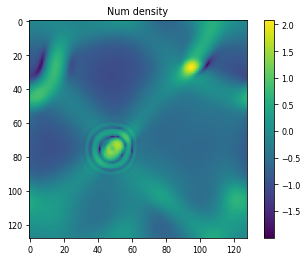

/home/xerox/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from float128 to float64 for imshow
  fig.canvas.print_figure(bytes_io, **kw)


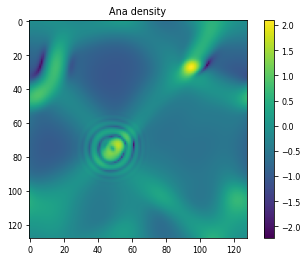

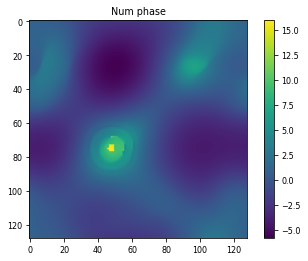

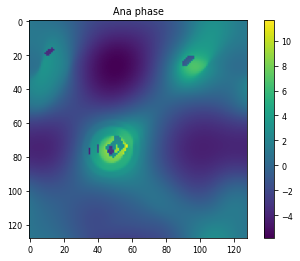

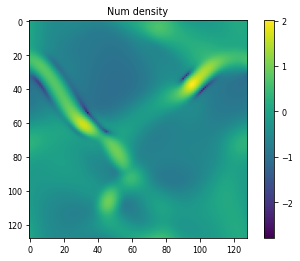

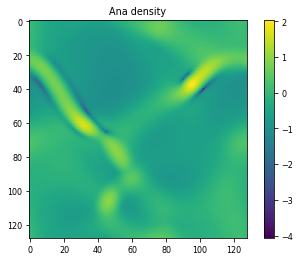

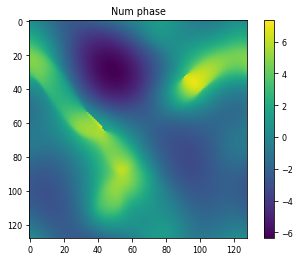

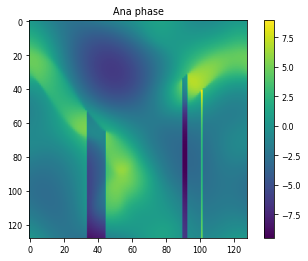

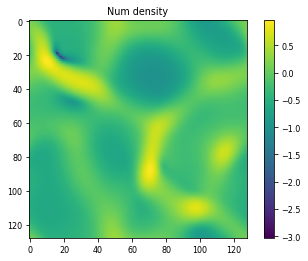

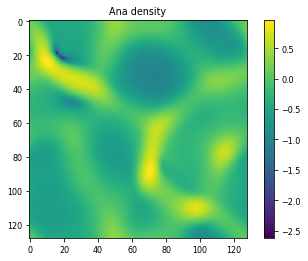

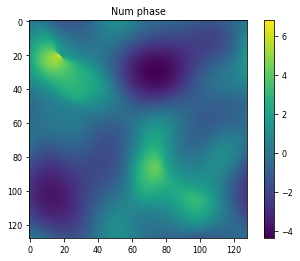

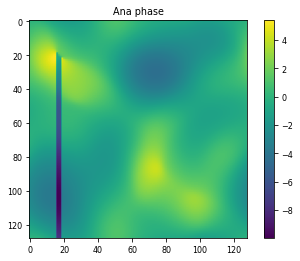

In [73]:
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []
y6 = []
y7 = []
relerr = []

slices = [np.s_[38,:,:], np.s_[:,26,:], np.s_[:, :, 13]]
for s in slices:
    y1.append(phaseCurvature(phase, solver.dx)[s])
    y2.append((quantumPressure(density, solver.dx)[s] * solver.dx**2))
    y3.append(deltaSi(density, phase, solver.dx)[s])
    y7.append(np.abs(deltaSi(density, phase, solver.dx)[s]) > 10)
    y4.append(np.abs(quantumPressure(density, solver.dx) * solver.dx**2)[s] > 0.05)
    y5.append(getVelocity(y3[-1], solver.dx)* solver.dx**2)
    y6.append(getCurvature(y3[-1], solver.dx) * solver.dx**2)
    relerr.append(np.abs(density[s] - np.abs(psi[s])**2)/density[s])

    plt.title("Num density")
    plt.imshow(np.log10(density[s]))
    plt.colorbar()
    plt.show()

    plt.title("Ana density")
    plt.imshow(np.log10(np.abs(psi[s])**2))
    plt.colorbar()
    plt.show()

    plt.title("Num phase")
    plt.imshow(phase[s])
    plt.colorbar()
    plt.show()

    plt.title("Ana phase")
    plt.imshow(fd.make_continuous(np.angle(psi))[s])
    plt.colorbar()
    plt.show()

In [54]:
dslice1  = density[38, :, :]
pslice1  = phase[38, :, :]
dslice2  = density[:, 26, :]
pslice2  = phase[:, 26, :]
dslice3  = density[:, :, 13]
pslice3  = phase[:, :, 13]

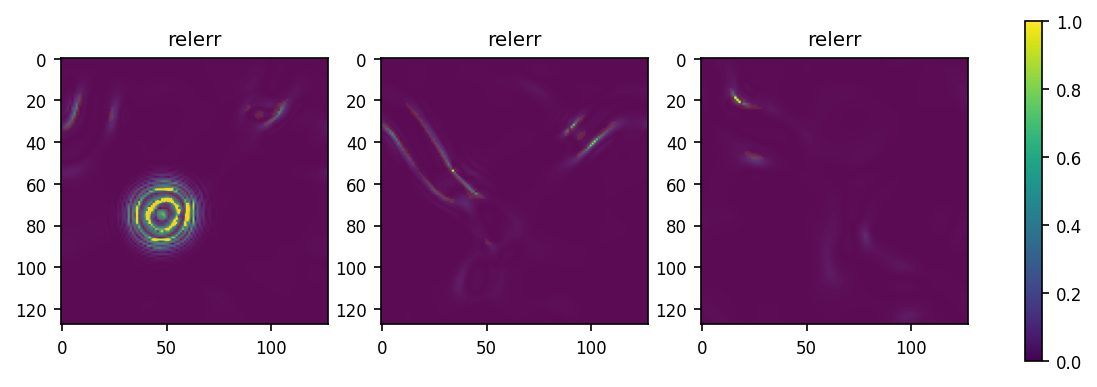

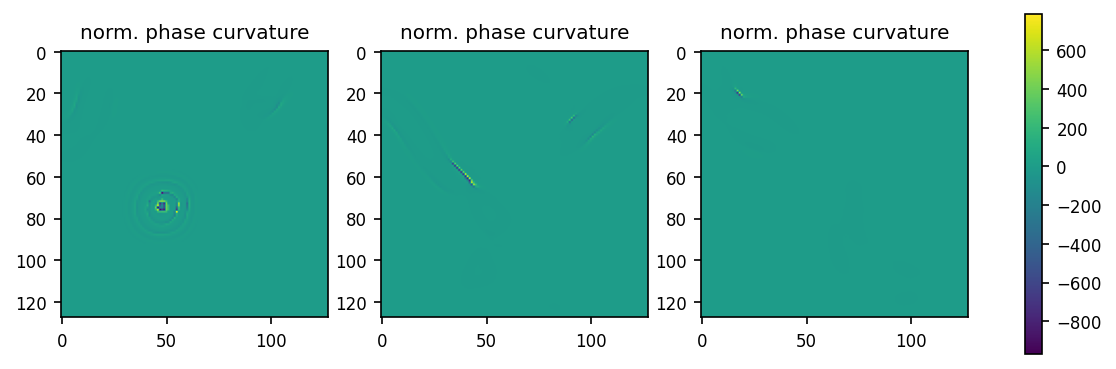

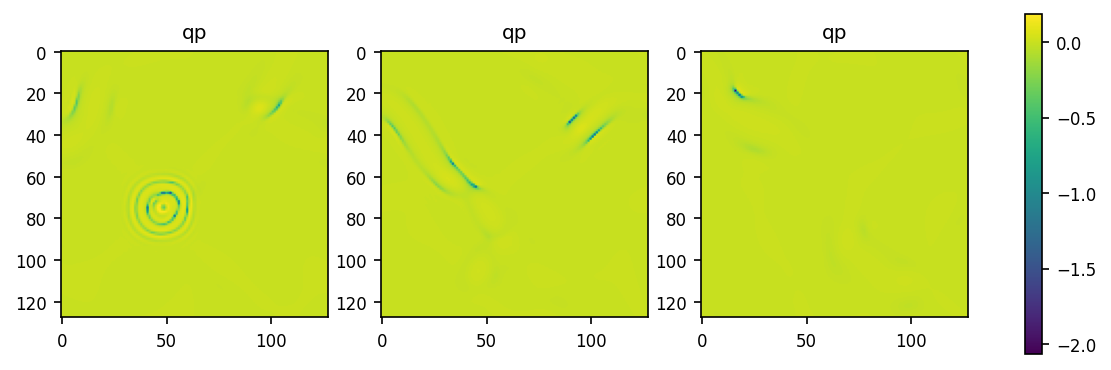

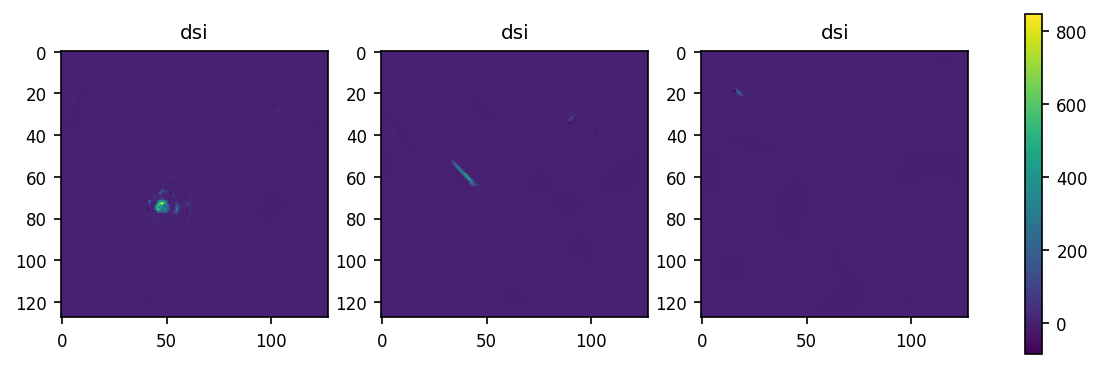

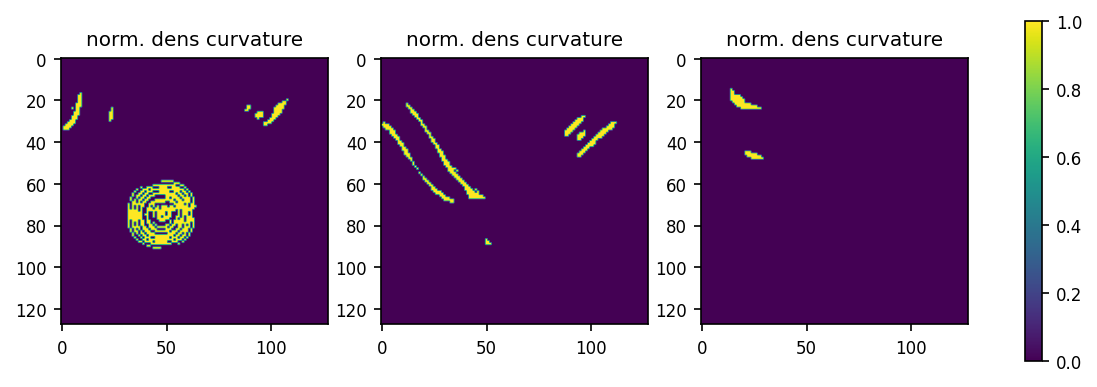

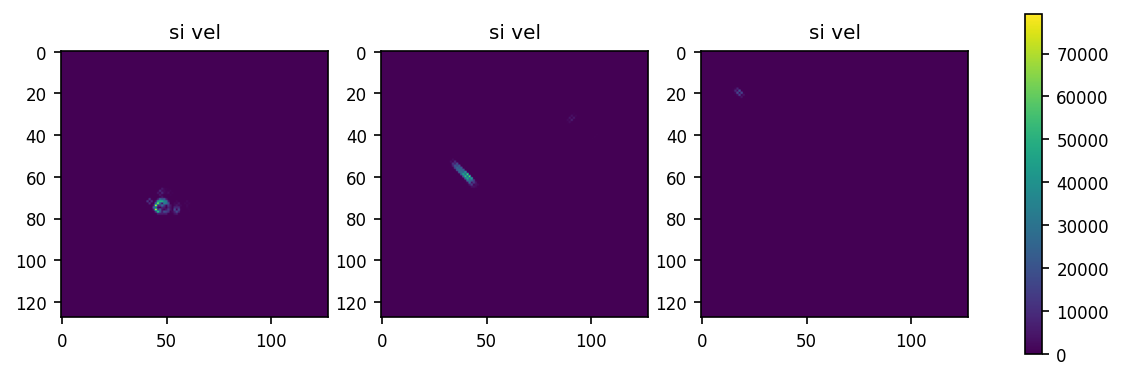

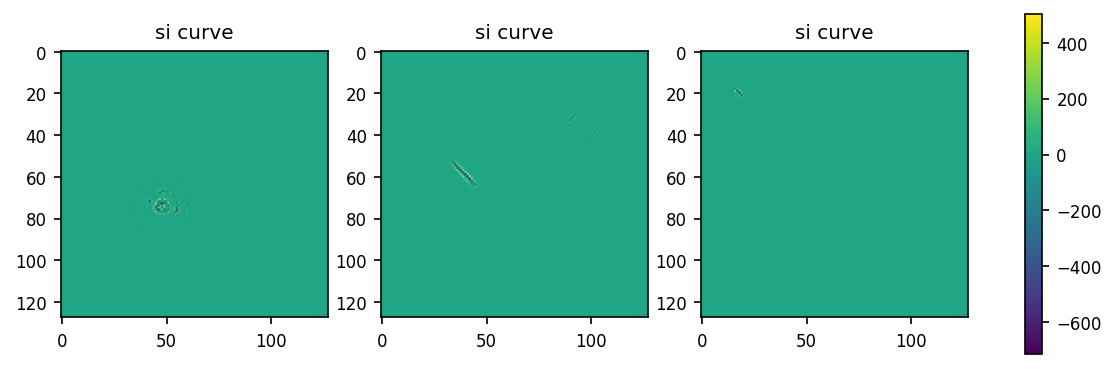

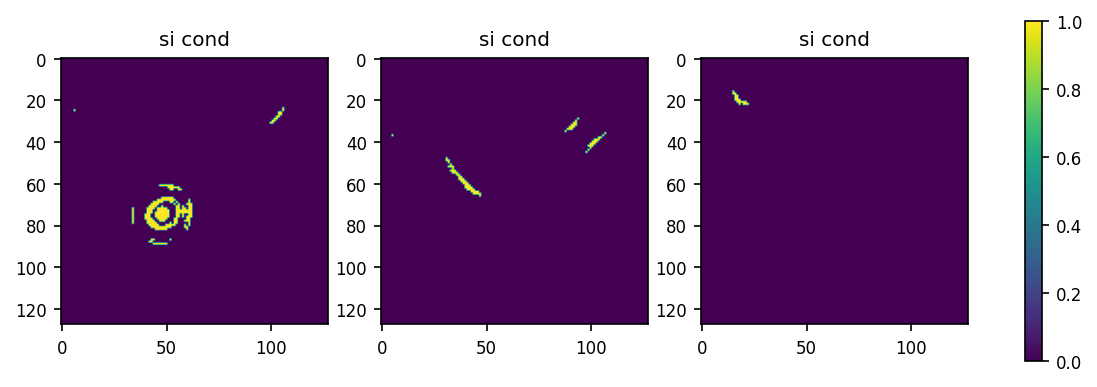

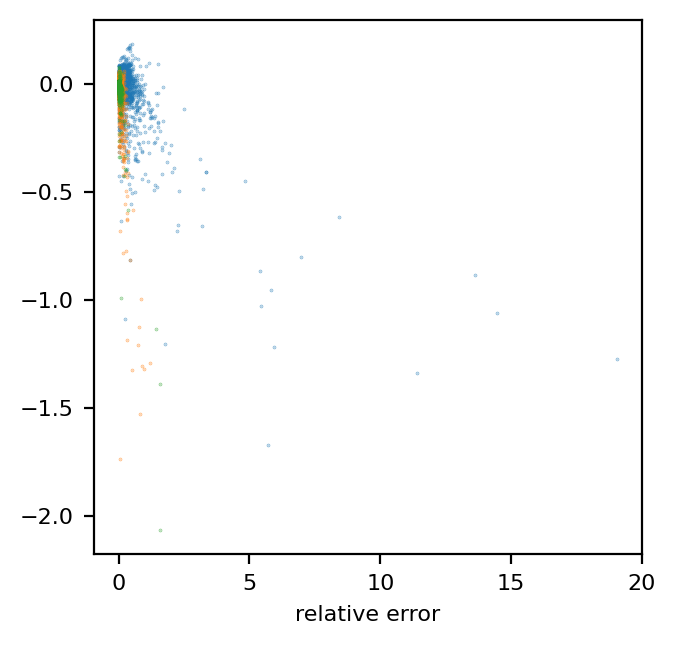

In [74]:
plotEverything(y1, y2, y3, y4, y5, y6, y7, relerr, dx)